<a href="https://colab.research.google.com/github/yash2029/Image-Indexing/blob/master/Project_Final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 186 kB 5.2 MB/s 
     |████████████████████████████████| 56 kB 3.5 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

import fastai
from fastai import *
from fastai.vision import *
from fastai.imports import *

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.data import ImageDataLoaders
from fastai.vision.learner import cnn_learner
from fastai.vision.all import *

from fastai.metrics import accuracy_multi
from fastai.metrics import APScoreMulti

from torchvision.models import resnet34
fastai.__version__

'2.5.2'

In [4]:
!wget https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
!unzip UCMercedLanduse.zip

--2021-09-22 06:08:52--  https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u83ae1efaah2w9o/UCMercedLanduse.zip [following]
--2021-09-22 06:08:53--  https://www.dropbox.com/s/raw/u83ae1efaah2w9o/UCMercedLanduse.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc62b60cfd6344d6dbb8c06c7c37.dl.dropboxusercontent.com/cd/0/inline/BWoireRT5G3tOxVltWMCPYeVis3OKtwZ40owJIeQo5uylOXHxwVRIcsBFkcqFSSbgiRhZ79Xs1vzqRJ3ThLHvWfBzafqV_B_WIqRKmAI8LgCv-xlohfCUOypxtg5ajwpHgkr42zca34R5FxlCRGrBeL1/file# [following]
--2021-09-22 06:08:53--  https://uc62b60cfd6344d6dbb8c06c7c37.dl.dropboxusercontent.com/cd/0/inline/BWoireRT5G3tOxVltWMCPYeVis3OKtwZ40owJIeQo5uylOXHxwVRIcsBFkcqFSSbgiRhZ

In [5]:
df = pd.read_csv("UCMerced/multilabels.txt", sep="\t")
df.head()

,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
0,agricultural00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,agricultural01,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,agricultural02,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,agricultural03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,agricultural04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [6]:
class_count = pd.DataFrame(df.sum(axis=0)).reset_index()
class_count.columns = ["class", "Count"]
class_count.drop(class_count.index[0], inplace=True)
class_count

,class,Count
1,airplane,100
2,bare-soil,718
3,buildings,691
4,cars,886
5,chaparral,115
6,court,105
7,dock,100
8,field,103
9,grass,975
10,mobile-home,102


In [7]:
classes = list(class_count['class'])
df = pd.read_csv("UCMerced/multilabels.txt", sep="\t")
df1 = pd.DataFrame({"image_name":[],
                         "tags":[]})

for i in range(len(df)):
  tag_str = ""
  for j in range(0,17):
    if df.at[i,classes[j]] == 1:
      tag_str = tag_str + ' ' + classes[j]
  tag_str = tag_str.strip()  
  df1 = df1.append({"image_name":df.at[i,'IMAGE\LABEL'] + '.tif', "tags": tag_str}, ignore_index=True)
  
df1.head()

,image_name,tags
0,agricultural00.tif,field trees
1,agricultural01.tif,field
2,agricultural02.tif,field
3,agricultural03.tif,field
4,agricultural04.tif,trees


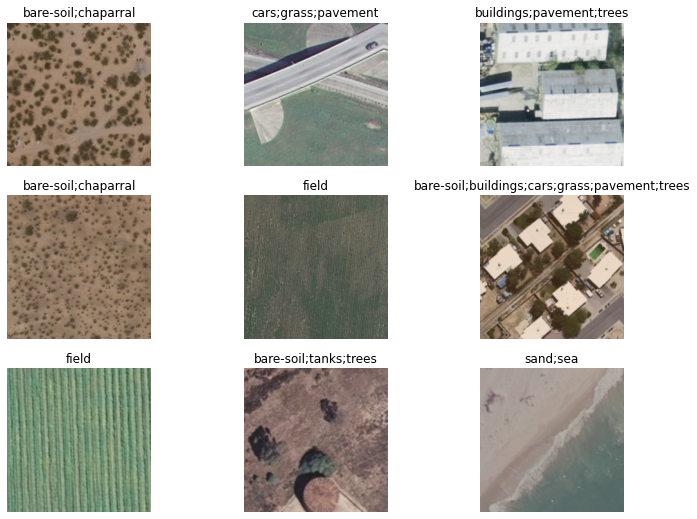

In [8]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'UCMerced/images/'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms = RandomResizedCrop(224, min_scale=0.75, ratio=(1.,1.)),
                   batch_tfms = batch_tfms)
dls = planet.dataloaders(df1)
dls.show_batch(max_n=9, figsize=(12,9))

In [19]:
resnet = cnn_learner(dls, models.resnet34, metrics=[accuracy_multi, APScoreMulti()])
squeezenet = cnn_learner(dls, models.squeezenet1_0, metrics=[accuracy_multi, APScoreMulti()])
densenet = cnn_learner(dls, models.densenet121, metrics=[accuracy_multi, APScoreMulti()])
vgg16 = cnn_learner(dls, models.vgg16_bn, metrics=[accuracy_multi, APScoreMulti()])
alex = cnn_learner(dls, models.alexnet, metrics=[accuracy_multi, APScoreMulti()])

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [13]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

resnet.loss_func = BCEWithLogitsLossFlat()
squeezenet.loss_func = BCEWithLogitsLossFlat()
densenet.loss_func = BCEWithLogitsLossFlat()
vgg16.loss_func = BCEWithLogitsLossFlat()
alex.loss_func = BCEWithLogitsLossFlat()

SuggestedLRs(valley=0.0014454397605732083)

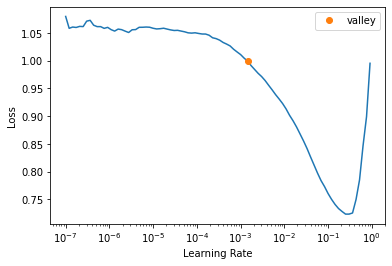

In [11]:
resnet.lr_find()

In [14]:
lr = 1e-2
resnet = resnet.to_fp16()
resnet.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.747608,0.396775,0.836415,0.896057,00:16
1,0.419331,0.142336,0.941316,0.931777,00:13
2,0.277346,0.128081,0.945098,0.950584,00:13
3,0.205628,0.121044,0.950420,0.954888,00:13
4,0.167032,0.117709,0.952661,0.956835,00:14


SuggestedLRs(valley=0.0020892962347716093)

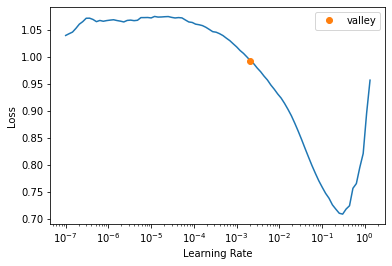

In [15]:
squeezenet.lr_find()

In [16]:
lr = 1e-2
squeezenet = squeezenet.to_fp16()
squeezenet.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.711852,0.360204,0.873809,0.876726,00:09
1,0.405552,0.145343,0.940756,0.931626,00:09
2,0.273030,0.131949,0.946919,0.949677,00:09
3,0.205139,0.125152,0.946359,0.953376,00:09
4,0.167838,0.123480,0.948039,0.953656,00:09


SuggestedLRs(valley=0.0010000000474974513)

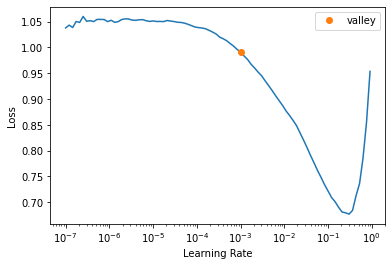

In [17]:
densenet.lr_find()

In [18]:
lr = 1e-2
densenet = densenet.to_fp16()
densenet.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.683612,0.338875,0.877311,0.909280,00:37
1,0.378378,0.144550,0.941457,0.944858,00:28
2,0.247608,0.124759,0.950000,0.957915,00:29
3,0.182801,0.118501,0.953782,0.964268,00:29
4,0.144017,0.115433,0.954762,0.965163,00:29


SuggestedLRs(valley=0.001737800776027143)

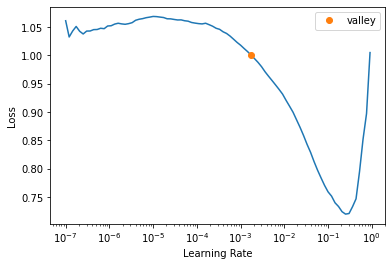

In [20]:
vgg16.lr_find()

In [21]:
lr = 1e-2
vgg16 = vgg16.to_fp16()
vgg16.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.727184,0.325480,0.898880,0.869956,00:52
1,0.415747,0.144459,0.939636,0.925904,00:36
2,0.275756,0.130473,0.948880,0.947303,00:36
3,0.207462,0.124122,0.949300,0.952404,00:36
4,0.167541,0.120478,0.951261,0.954693,00:36


SuggestedLRs(valley=0.0014454397605732083)

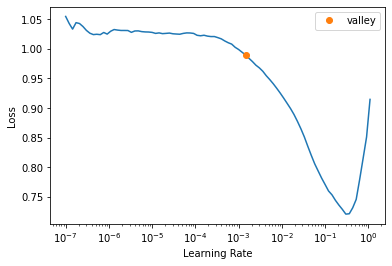

In [22]:
alex.lr_find()

In [23]:
lr = 1e-2
alex = alex.to_fp16()
alex.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.745368,0.387269,0.851120,0.863447,00:08
1,0.429744,0.164786,0.934734,0.904203,00:07
2,0.293374,0.148401,0.939496,0.923709,00:07
3,0.226986,0.141612,0.941316,0.931902,00:07
4,0.188171,0.138748,0.942717,0.933963,00:07


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
model_save1 = 'Resnet_DS1.pt'
path1 = Path(F"/content/gdrive/My Drive/{model_save1}")
resnet.export(path1)

model_save2 = 'Squeezenet_DS1.pt'
path2 = Path(F"/content/gdrive/My Drive/{model_save2}")
squeezenet.export(path2)

model_save3 = 'Densenet_DS1.pt'
path3 = Path(F"/content/gdrive/My Drive/{model_save3}")
densenet.export(path3)

model_save4 = 'Vgg16_DS1.pt'
path4 = Path(F"/content/gdrive/My Drive/{model_save4}")
vgg16.export(path4)

model_save5 = 'Alexnet_DS1.pt'
path5 = Path(F"/content/gdrive/My Drive/{model_save5}")
alex.export(path5)

!ls /content/gdrive/My\ Drive